# 1. 环境准备

## 1.1 加载依赖库

In [1]:
import numpy

from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
import tempfile
import string

import sys
import logging
import os
import pickle
import re
import matplotlib.pyplot as plt
%matplotlib inline

# 定义输出目录
output_path = r"C:\Users\29791\Desktop\数据"
if not os.path.exists(output_path):
    os.mkdir(output_path)
    
import warnings
warnings.simplefilter('ignore')

plt.rcParams['font.family'] = 'sans-serif'  # 用来正常显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False  # 设置正常显示符号

## 1.2 导入Gensim

In [2]:
from glob import glob
import re
import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
import pandas as pd

# 启用日志，用以绘制Gensim建模曲线
import logging
logging.basicConfig(filename = r"C:\Users\29791\Desktop\数据\result\gensim.log",
                   format = '%(asctime)s:%(levelname)s:%(message)s',
                   level = logging.INFO)

## 1.3 加载数据集

In [3]:
# 设置文件路径
pickle_file_path = r"C:\Users\29791\Desktop\数据\Content_V3.0.pkl"

# 加载数据
# 加载pickle文件到DataFrame
with open(pickle_file_path, 'rb') as f:
    df = pickle.load(f)
    
# 指定列名
df.columns = ['Title', 'Source', 'Date', 'Content']


df

Title              Source  \
0     Xi suggests China, C.Asia build Silk Road econ...              Xinhua   
1         President Xi proposes Silk Road economic belt              Xinhua   
2                    Xi proposes a 'new Silk Road' belt         China Daily   
3        Xi'an forum focuses on Silk Road Economic Belt   chinadaily.com.cn   
4         China loans Gabon over $133m for road project              Xinhua   
...                                                 ...                 ...   
2693  China-proposed BRI helps nations improve gover...  China Daily Global   
2694            BRI role in global green efforts hailed  China Daily Global   
2695    China eyes BRI tie-ups in green, digital fields         China Daily   
2696  Thai engineer proud to work for BRI's high-spe...   chinadaily.com.cn   
2697  Entrepreneurial journey from China to Vietnam:...   chinadaily.com.cn   

           Date                                            Content  
0    2013-09-07  ASTANA -- President Xi Jinping proposed here S...  
1    2013-09-07  ASTANA - Chinese President Xi Jinping proposed...  
2    2013-09-09  Enhanced links within the region could further...  
3    2013-09-27  The ongoing Euro-Asia Economic Forum in Xi'an ...  
4    2013-10-02  LIBREVILLE -- China has offered Gabon a prefer...  
...         ...                                                ...  
2693 2023-12-08  The China-proposed Belt and Road Initiative no...  
2694 2023-12-13  China-proposed initiative to help world achiev...  
2695 2023-12-16  In the next phase of the Belt and Road Initiat...  
2696 2023-12-18  Trin Phuanglamchiak, a Thai employee of the Ch...  
2697 2024-01-05  Amidst the thriving economic corridor linking ...  

[2698 rows x 4 columns]

### 1.3.1 提取Content内容

In [4]:
content_column = df['Content']

# 统计总单词数
def count_words(column):
    total_words = 0
    for text in column:
        words = text.split()       # 将文本分割成单词列表
        total_words += len(words)  # 统计单词数量
    return total_words

# 统计Content列单词数量
word_count_content = count_words(content_column)

print("Number of Words: {}.".format(word_count_content))

# 将DataFrame中的内容逐行写入txt文件
# txt_file = r"C:\Users\29791\Desktop\数据\result\Content_V3.0.txt"
# with open(txt_file, "w", encoding="utf-8") as f:
    # for content in content_column:
        # f.write(content + "\n")

# print("Conversion completed. Text file saved as:", txt_file)

content_column

Number of Words: 1357192.


0       ASTANA -- President Xi Jinping proposed here S...
1       ASTANA - Chinese President Xi Jinping proposed...
2       Enhanced links within the region could further...
3       The ongoing Euro-Asia Economic Forum in Xi'an ...
4       LIBREVILLE -- China has offered Gabon a prefer...
                              ...                        
2693    The China-proposed Belt and Road Initiative no...
2694    China-proposed initiative to help world achiev...
2695    In the next phase of the Belt and Road Initiat...
2696    Trin Phuanglamchiak, a Thai employee of the Ch...
2697    Amidst the thriving economic corridor linking ...
Name: Content, Length: 2698, dtype: object

# 2. 数据预处理

## 2.1 文本分词

In [5]:
import nltk
import string
from nltk.corpus import stopwords
from nltk import pos_tag
from gensim.parsing.preprocessing import STOPWORDS
from IPython.core.debugger import set_trace  # 调试代码库

# 移除默认停用词并加入自定停用词
# nltk.download('wordnet')
# 读取 "stopwords.txt" 文件
with open(r"C:\Users\29791\Desktop\数据\stopwords.txt", "r") as file:
    custom_stopwords = set(file.read().splitlines())

# 合并停用词集合
stop = set(stopwords.words('english')).union(set(STOPWORDS)).union(custom_stopwords)

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def process(text):
    # 转换大小写
    text = text.lower()

    # 去除标点和数字
    for c in string.punctuation:
        text = text.replace(c, ' ')
    for c in string.digits:
        text = text.replace(c, '')

    text = nltk.word_tokenize(text) # 分割成单词

    # 保留长度不小于3的单词，去除停用词，并验证是否为英文单词
    lemmatizer = WordNetLemmatizer()               # 词形还原
    # stemmer = SnowballStemmer(language='english')  # 词干提取，用的时候记得删掉#
    words_filt = []
    for word, pos in pos_tag(text):  # 对每个单词进行词性标注
        wordnet_pos = get_wordnet_pos(pos)  # 获取 WordNet 词性标记
        if wordnet_pos is not None and len(word) >= 3 and wordnet.synsets(word):
            word = lemmatizer.lemmatize(word, pos=wordnet_pos)  # 使用词性进行词形还原
            # word = stemmer.stem(word)  # 可选的词干提取，效果不佳
            # 对词形还原后的语料库去除停用词
            if word not in stop:
                words_filt.append(word)

    return words_filt

df['tokens'] = df['Content'].apply(process)

# 初始化token总数
total_words = 0

# 遍历每个单词列表，计算单词数量
for tokens_list in df['tokens']:
    total_words += len(tokens_list)

# 输出处理后总token数
print("Number of Tokens: {}.".format(total_words))

# 输出分词结果，获得语料库
# print(stop)
print(df.tokens)

Number of Tokens: 559580.
0       [astana, propose, saturday, china, asia, join,...
1       [propose, saturday, china, asia, join, hand, b...
2       [enhanced, link, region, advance, global, econ...
3       [ongoing, euro, economic, focus, construction,...
4       [libreville, china, offer, gabon, preferential...
                              ...                        
2693    [china, propose, benefit, participate, nation,...
2694    [china, propose, achieve, paris, agreement, go...
2695    [phase, china, accelerate, collaborative, form...
2696    [thai, employee, china, construction, engineer...
2697    [thriving, economic, corridor, link, southwest...
Name: tokens, Length: 2698, dtype: object


## 2.2 生成词云图

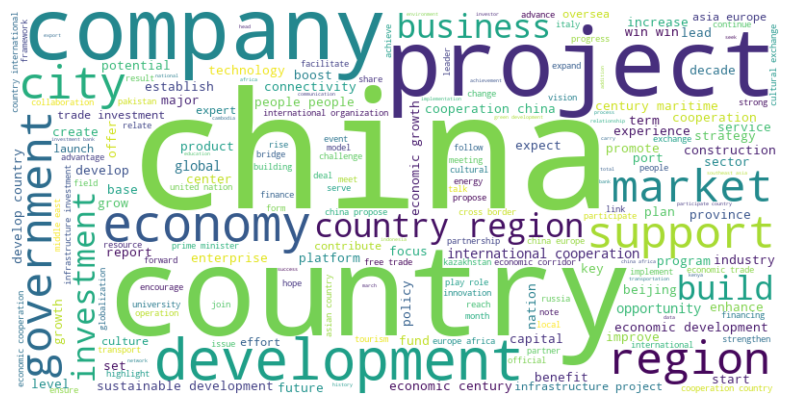

Top 50 Words with Frequency Ratio and Cumulative Ratio:
                Frequency  Frequency Ratio  Cumulative Ratio
china               20119         0.035954          0.035954
country             12581         0.022483          0.058437
cooperation          8487         0.015167          0.073603
development          7426         0.013271          0.086874
economic             5574         0.009961          0.096835
project              5180         0.009257          0.106092
trade                5098         0.009110          0.115202
international        4959         0.008862          0.124064
investment           3938         0.007037          0.131102
people               3830         0.006844          0.137946
infrastructure       3779         0.006753          0.144700
global               3388         0.006055          0.150754
region               2936         0.005247          0.156001
company              2901         0.005184          0.161185
economy              2501    

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import pandas as pd

# 生成词云的函数
def generate_wordcloud(text):
    
    # 将tokens列表中的词汇连接成一个字符串
    text = ' '.join(df['tokens'].explode())
    
    # 创建WordCloud对象
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 生成词云图
generate_wordcloud(df['tokens'])

# 统计词频
word_freq = Counter(word for sublist in df['tokens'] for word in sublist)

# 将词频统计结果转换为 DataFrame
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])

# 对词频进行降序排序
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# 输出词频最高的前50个词
top_50_words = word_freq_df.head(50)

# 计算整个语料库的词频总和
total_freq_corpus = word_freq_df['Frequency'].sum()

# 计算每个词的词频占比和累计占比
top_50_words['Frequency Ratio'] = top_50_words['Frequency'] / total_freq_corpus
top_50_words['Cumulative Ratio'] = top_50_words['Frequency Ratio'].cumsum()

# 输出结果
print("Top 50 Words with Frequency Ratio and Cumulative Ratio:")
print(top_50_words)


# 3. 提取语料库特征

In [7]:
# 构建词袋语料库

def nltk_stopwords():
    return set(stopwords.words('english'))

def prep_corpus(docs, additional_stopwords = set(), no_below = 3, no_above = 0.5):
    print("建立词典……")
    
    # 根据输入文档建立词典
    # token列
    dictionary = Dictionary(docs)
    stopwords = nltk_stopwords().union(additional_stopwords)
    
    # 为停用词映射Token ID
    stopword_ids = map(dictionary.token2id.get, stopwords)
    
    # 过滤停用词的Token ID
    dictionary.filter_tokens(stopword_ids)
    
    # 为词典中的分词分配ID
    dictionary.compactify()
    
    # 进一步过滤不少于三个字母，同时占比不超过整个语料库50%的token
    # 占比过多的token往往是常用词，对于主题建模价值不大
    dictionary.filter_extremes(no_below = no_below, no_above = no_above, keep_n = None)
    print(dictionary)
    
    # 再次为词典中的分词分配ID
    dictionary.compactify()
    
    # 建立独立分词字典后，调用doc2bow构建BoW语料库
    print("构建语料库特征……")
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    return dictionary, corpus

In [8]:
# 对标记列tokens构建语料库，并输出字典统计
dictionary, corpus = prep_corpus(df.tokens)

# 统计词袋语料库单词数
def count_words(corpus):
    total_words = 0
    for doc in corpus:
        for word_id, count in doc:
            total_words += count
    return total_words

# 统计词袋语料库中的单词数量
word_count_corpus = count_words(corpus)

print("Number of Tokens in Corpus: {}.".format(word_count_corpus))

建立词典……
Dictionary<6641 unique tokens: ['asia', 'astana', 'boost', 'build', 'deliver']...>
构建语料库特征……
Number of Tokens in Corpus: 469860.


In [10]:
# 生成共现矩阵
from collections import defaultdict

# 将文本列表合并成一个字符串
corpus_text = ' '.join(df['tokens'].explode())

# 提取词频最高的27个词的名称，依据二八定律得出
top_27_words = word_freq_df.head(27)
top_27_words_list = top_27_words.index.tolist()

# 指定窗口大小
window_size = 7

# 初始化共现矩阵
co_occurrence_matrix = defaultdict(lambda: defaultdict(int))

# 分词
words = corpus_text.split()

# 遍历文本中的词语对
for i, word1 in enumerate(words):
    if word1 in top_27_words_list:
        start = max(0, i - window_size)
        end = min(len(words), i + window_size + 1)
        for word2 in words[start:end]:
            if word2 != word1 and word2 in top_27_words_list:  # 排除词与自身共现的情况
                co_occurrence_matrix[word1][word2] += 1

# 将共现矩阵转换为普通的字典
co_occurrence_matrix = dict(co_occurrence_matrix)

# 打印共现矩阵
print("Co-occurrence Matrix:")
for word1 in top_27_words_list:
    row = [co_occurrence_matrix[word1][word2] for word2 in top_27_words_list]
    print(word1, row)

Co-occurrence Matrix:
china [0, 7491, 5076, 3664, 3053, 2213, 3092, 2429, 2108, 1595, 1554, 1582, 1348, 1095, 1318, 1270, 1127, 1423, 950, 988, 802, 1135, 1499, 897, 956, 661, 1274]
country [7491, 0, 3481, 2561, 1886, 1524, 1969, 1678, 1519, 1344, 1245, 926, 1751, 794, 749, 757, 883, 662, 516, 712, 588, 671, 582, 668, 431, 506, 543]
cooperation [5076, 3481, 0, 1963, 1586, 936, 1271, 2276, 806, 874, 739, 669, 512, 272, 512, 627, 977, 321, 265, 436, 286, 500, 305, 760, 396, 348, 439]
development [3664, 2561, 1963, 0, 1858, 876, 652, 989, 654, 790, 990, 1038, 532, 270, 597, 440, 951, 278, 273, 550, 230, 516, 225, 292, 299, 305, 390]
economic [3053, 1886, 1586, 1858, 0, 622, 1286, 607, 556, 470, 673, 707, 486, 199, 447, 486, 509, 501, 215, 313, 178, 205, 346, 274, 249, 223, 262]
project [2213, 1524, 936, 876, 622, 0, 324, 426, 749, 457, 1125, 323, 361, 580, 231, 339, 237, 217, 220, 229, 269, 352, 167, 105, 625, 304, 259]
trade [3092, 1969, 1271, 652, 1286, 324, 0, 688, 1157, 641, 967, 511,

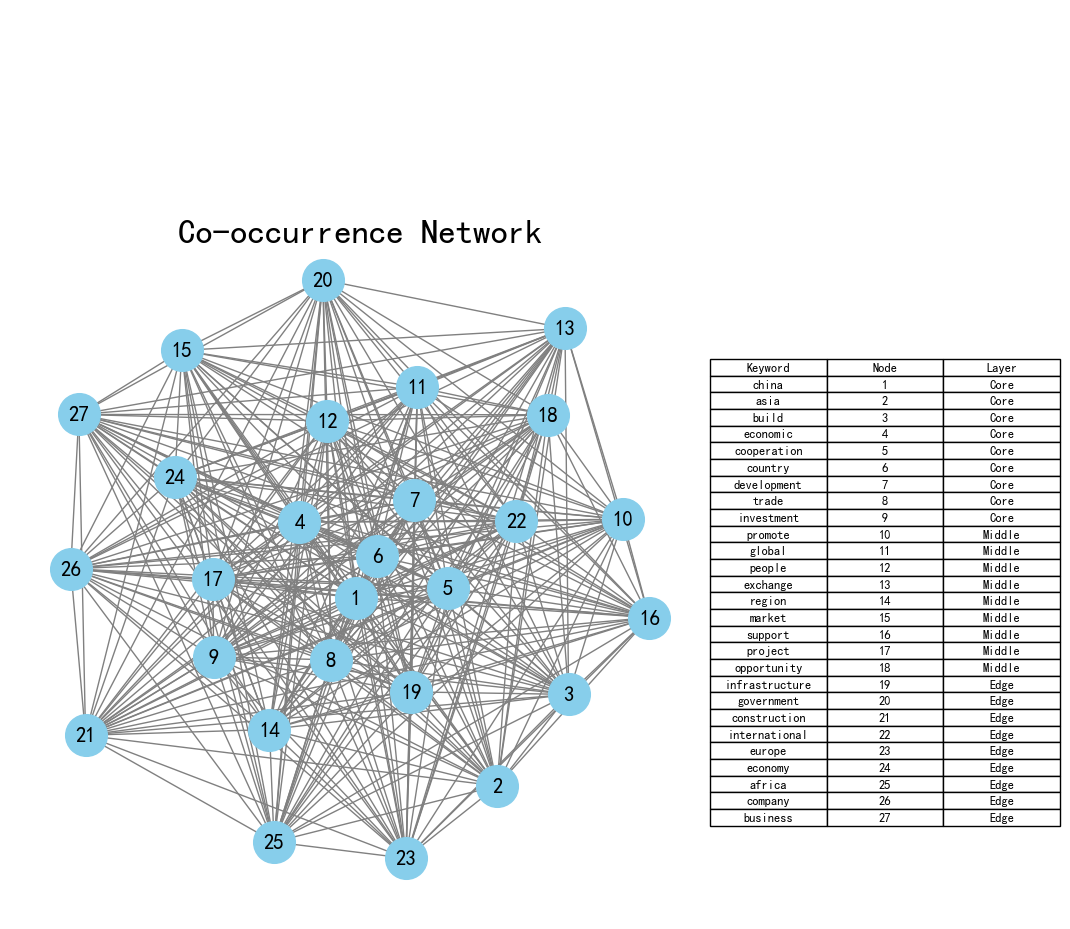

In [35]:
import networkx as nx

# 创建图
G = nx.Graph()

# 添加节点
for word1 in co_occurrence_matrix:
    G.add_node(word1)

# 添加边
for word1, edges in co_occurrence_matrix.items():
    for word2, weight in edges.items():
        if word1 != word2:  # 排除词与自身共现的情况
            G.add_edge(word1, word2, weight=weight)

# 计算节点的度中心性
degree_centrality = nx.degree_centrality(G)

# 根据度中心性将节点分为“核心层-中间层-边缘层”三个层次
sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
num_nodes = len(sorted_nodes)
core_layer_nodes = [node for node, centrality in sorted_nodes[:num_nodes // 3]]
middle_layer_nodes = [node for node, centrality in sorted_nodes[num_nodes // 3:2 * num_nodes // 3]]
edge_layer_nodes = [node for node, centrality in sorted_nodes[2 * num_nodes // 3:]]

# 根据层次对节点进行编号
node_labels = {}
node_count = 1
for nodes in [core_layer_nodes, middle_layer_nodes, edge_layer_nodes]:
    for node in nodes:
        node_labels[node] = node_count
        node_count += 1

# 创建节点标签映射表格，包括节点所在的层次信息
layer_labels = ['Core'] * len(core_layer_nodes) + ['Middle'] * len(middle_layer_nodes) + ['Edge'] * len(edge_layer_nodes)
node_table = pd.DataFrame({'Keyword': list(node_labels.keys()), 'Node': list(node_labels.values()), 'Layer': layer_labels})

# 根据层次布局节点
pos = nx.spring_layout(G, k=0.7)  # 使用 Spring layout 布局算法，并调整 k 值使得节点之间稍微紧凑一点
for node in core_layer_nodes:
    pos[node] = (pos[node][0] * 0.1, pos[node][1] * 0.1)  # 将“核心层”的节点放置在网络图的中心位置
for node in middle_layer_nodes:
    pos[node] = (pos[node][0] * 0.1, pos[node][1] * 0.1)  # 将“中间层”的节点放置在“核心层”和“边缘层”之间
for node in edge_layer_nodes:
    pos[node] = (pos[node][0] * 0.1, pos[node][1] * 0.1)  # 将“边缘层”的节点放置在网络图的边缘位置

# 绘制网络图
plt.figure(figsize=(7, 7))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=900, node_color="skyblue", font_size=15, font_weight="bold", width=1, edge_color="gray")

# 创建节点标签表格，并调整位置
table_ax = plt.gca().inset_axes([1, 0.8, 0.5, 0.5])  # 调整表格位置
table_ax.axis('off')  # 关闭坐标轴
table_ax.table(cellText=node_table.values, colLabels=node_table.columns, cellLoc='center')

# 设置共用标题
plt.suptitle("Co-occurrence Network", fontsize=25, y=1)

plt.show()


In [9]:
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (8, 3), (9, 1), (10, 1), (11, 2), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 2), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 4), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 3), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 

In [10]:
# 将语料库存储为Matrix Market Exchange格式，以便使用corpora.MmCorpus重新加载
MmCorpus.serialize(r"C:\Users\29791\Desktop\数据\result\Content_V3.0.mm", corpus)
dictionary.save(r"C:\Users\29791\Desktop\数据\result\Content_V3.0.dict")

# 4. 确定主题个数

Optimal Number of Topics: 2
Coherence Score for Optimal Number of Topics: -0.9036520499546685


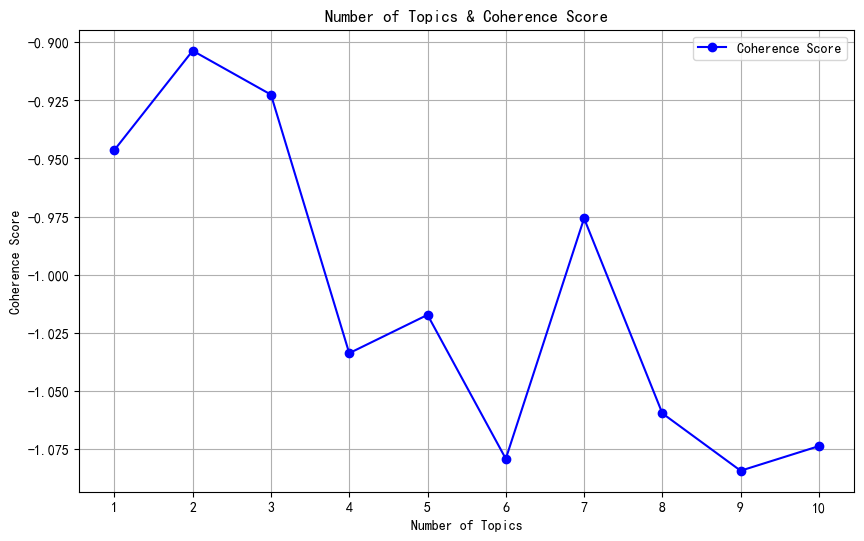

[-0.9463558498973635, -0.9036520499546685, -0.9225323136501556, -1.0337368019241144, -1.0172598480229413, -1.0791554574134157, -0.9757525450020187, -1.0596188454889048, -1.0842931095412056, -1.0737110912463932]


In [55]:
# 使用网格搜索找到最佳数量的主题
from gensim.models.coherencemodel import CoherenceModel
# 指定要在其中搜索的主题数量范围
min_topics = 1
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)
 
# 执行网格搜索并计算不同数量主题的一致性分数
coherence_scores = []
for num_topics in topics_range:
    lda_model = models.ldamodel.LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics)
    coherence_model_lda = CoherenceModel(model = lda_model, texts = df.tokens, dictionary = dictionary, coherence = 'u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

# 找出具有最高连贯分数的最佳主题数量
optimal_num_topics = topics_range[numpy.argmax(coherence_scores)]
print("Optimal Number of Topics:", optimal_num_topics)
print("Coherence Score for Optimal Number of Topics:", max(coherence_scores))
 
# 绘制主题数与连贯分数之间的关系
plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker = 'o', color = 'b', label = 'Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Number of Topics & Coherence Score')
plt.xticks(topics_range)
plt.legend()
plt.grid(True)
plt.show()

# 打印不同主题数对应的一致性分数
print(coherence_scores)

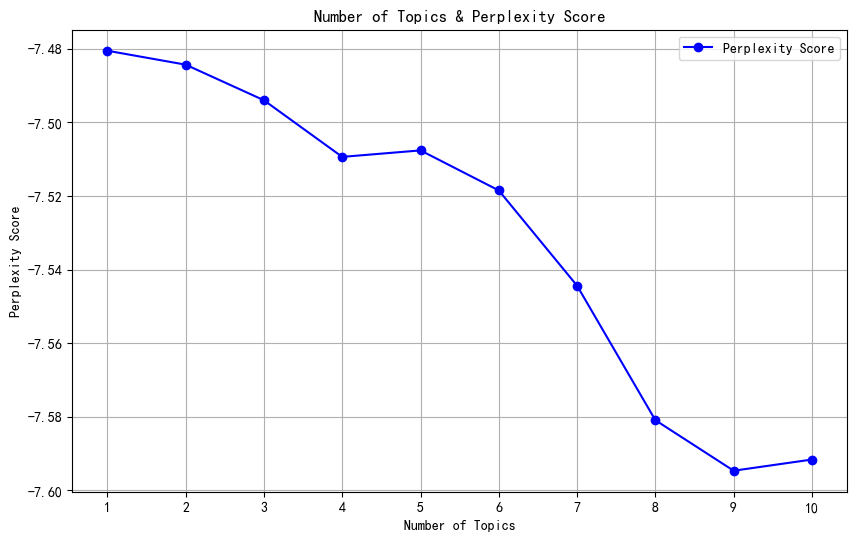

In [40]:
# 指定要在其中搜索的主题数量范围
min_topics = 1
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# 计算困惑度与主题数关系
perplexity_scores = []

for num_topics in topics_range:
    lda_model = models.ldamodel.LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics)
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity)

# 绘制主题数与困惑度之间的关系
plt.figure(figsize=(10, 6))
plt.plot(topics_range, perplexity_scores, marker='o', color='b', label='Perplexity Score')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.title('Number of Topics & Perplexity Score')
plt.xticks(topics_range)
plt.legend()
plt.grid(True)
plt.show()

# 5. LDA主题建模

In [15]:
lda_model = models.ldamodel.LdaModel(corpus = corpus,      # 指定语料库
                                    id2word = dictionary,  # 指定字典
                                    num_topics = 4,        # 指定汇总主题数量
                                    eval_every = 10,       # 模型复杂度计算
                                    passes = 50,           # 整个语料库上训练模型的频次，类似于epoch
                                    iterations = 5000,     # 迭代次数
                                    random_state = numpy.random.RandomState(15))  # 随机种子

# 打印主题
print(lda_model.print_topics())

# 计算连贯分数
# coherence_model = CoherenceModel(model=lda_model, texts=df.tokens, dictionary=dictionary, coherence='u_mass')
# coherence_score = coherence_model.get_coherence()
# 打印结果
# print(f'Coherence Score: {coherence_score}.')

[(0, '0.015*"railway" + 0.013*"port" + 0.011*"europe" + 0.010*"asia" + 0.010*"city" + 0.009*"region" + 0.008*"africa" + 0.007*"construction" + 0.006*"build" + 0.006*"province"'), (1, '0.014*"company" + 0.010*"energy" + 0.010*"market" + 0.009*"green" + 0.009*"region" + 0.008*"business" + 0.007*"service" + 0.007*"bank" + 0.007*"global" + 0.007*"economy"'), (2, '0.011*"promote" + 0.010*"exchange" + 0.010*"beijing" + 0.009*"support" + 0.009*"minister" + 0.006*"bilateral" + 0.006*"strengthen" + 0.006*"build" + 0.006*"cultural" + 0.005*"relation"'), (3, '0.017*"global" + 0.007*"benefit" + 0.007*"economy" + 0.006*"develop" + 0.006*"share" + 0.006*"build" + 0.006*"promote" + 0.006*"africa" + 0.006*"connectivity" + 0.006*"future"')]


In [12]:
lda_model2 = models.ldamodel.LdaModel(corpus = corpus,      # 指定语料库
                                    id2word = dictionary,  # 指定字典
                                    num_topics = 4,        # 指定汇总主题数量
                                    eval_every = 10,       # 模型复杂度计算
                                    passes = 50,           # 整个语料库上训练模型的频次，类似于epoch
                                    iterations = 5000,     # 迭代次数
                                    random_state = numpy.random.RandomState(8))  # 随机种子

# 打印主题
print(lda_model2.print_topics())

[(0, '0.015*"global" + 0.008*"promote" + 0.007*"benefit" + 0.007*"build" + 0.006*"africa" + 0.006*"connectivity" + 0.006*"economy" + 0.006*"develop" + 0.006*"share" + 0.006*"nation"'), (1, '0.014*"company" + 0.011*"energy" + 0.010*"railway" + 0.009*"port" + 0.009*"construction" + 0.007*"region" + 0.006*"export" + 0.006*"build" + 0.006*"market" + 0.006*"local"'), (2, '0.011*"bank" + 0.011*"region" + 0.009*"financial" + 0.009*"business" + 0.008*"market" + 0.008*"economy" + 0.008*"government" + 0.007*"service" + 0.007*"global" + 0.006*"promote"'), (3, '0.013*"cultural" + 0.011*"university" + 0.009*"culture" + 0.009*"exchange" + 0.008*"tourism" + 0.008*"student" + 0.007*"city" + 0.007*"language" + 0.006*"province" + 0.005*"region"')]


In [37]:
# 收敛测试
# p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
# matches = [p.findall(l) for l in open(r"C:\Users\29791\Desktop\数据\result\gensim.log")]
# matches = [m for m in matches if len(m) > 0]
# tuples = [t[0] for t in matches]
# perplexity = [float(t[1]) for t in tuples]
# liklihood = [float(t[0]) for t in tuples]
# iter = list(range(0, len(tuples)*10, 10))

# plt.plot(iter, liklihood, c = "black")
# plt.ylabel("Logarithmic Likelihood")    # 对数似然性
# plt.xlabel("Iterations")                # 迭代次数
# plt.title("Convergence of Topic Model") # 模型主题收敛度
# plt.show
# plt.grid()

# 6. LDA主题模型可视化

In [16]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()


# 指定LDA模型、语料库和字典
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# pyLDAvis主题id从1开始
pyLDAvis.display(vis_data)

In [14]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()


# 指定LDA模型、语料库和字典
vis_data = gensimvis.prepare(lda_model2, corpus, dictionary)

# pyLDAvis主题id从1开始
pyLDAvis.display(vis_data)